<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Работу выполнил: Лазуков Михаил

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [147]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision import transforms
import torch
import os
import skimage
import skimage.io
from skimage.transform import resize
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

%matplotlib inline

In [125]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img:resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [126]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [128]:
from sklearn.model_selection import train_test_split

train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_photos.transpose(0, 3, 1, 2).astype(np.float32), batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_photos.transpose(0, 3, 1, 2).astype(np.float32), batch_size=32, shuffle=False)

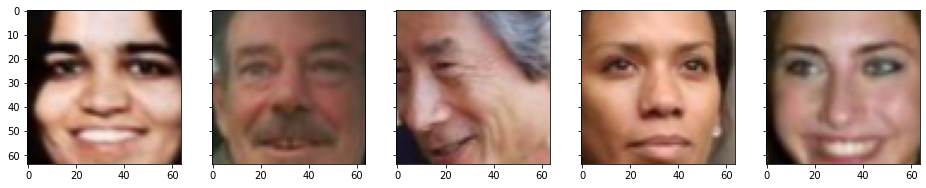

In [129]:
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(16, 8), \
                        sharey=True, sharex=True)
for fig_x in ax:
    random_characters = int(np.random.uniform(0,len(data)))
    fig_x.imshow(data[random_characters])

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [130]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x, only_decoder=False):
        if not only_decoder:
            latent_code = self.encoder(x)
            reconstruction = self.decoder(latent_code)
            return reconstruction, latent_code
        else:
            return self.decoder(x)


In [152]:
criterion = nn.MSELoss()

autoencoder = Autoencoder()

In [153]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [154]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [155]:
def train_epoch(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        preds, latent_code = model(batch)

        loss = criterion(preds, batch)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    return train_loss

In [156]:
def val_epoch(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            preds, latent_code = model(batch)

            loss = criterion(preds, batch)

            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    return val_loss

In [157]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = []
    model.to(device)
    for epoch in tqdm(range(epochs)):
        clear_output(wait=True)

        train_loss = train_epoch(model, criterion, optimizer, train_loader, device)
        val_loss = val_epoch(model, criterion, val_loader, device)
        print('Epoch: %d, train_loss: %f, val_loss: %f' % (epoch, train_loss, val_loss))

        history.append((train_loss, val_loss))
        

        id = int(np.random.uniform(0,len(val_loader)))
        val_image = val_loader.dataset[id]  
        fig, axes = plt.subplots(1, 2)

        axes[0].imshow(val_image.transpose(1, 2, 0))
        axes[0].set_title('Оригинал')

        pred, latent = model(torch.FloatTensor(val_image.reshape(-1, 3, 64, 64)).to(device))

        axes[1].imshow(pred[0].to('cpu').detach().numpy().transpose(1, 2, 0))
        axes[1].set_title('Восстановленное')
                
        plt.show()

    return history

Epoch: 99, train_loss: 0.003428, val_loss: 0.003161


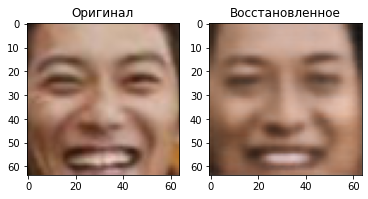



100%|██████████| 100/100 [08:24<00:00,  5.04s/it]


In [158]:
history = train(autoencoder, criterion, optimizer, train_loader, val_loader, 100, device)

In [159]:
train_loss, val_loss = zip(*history)

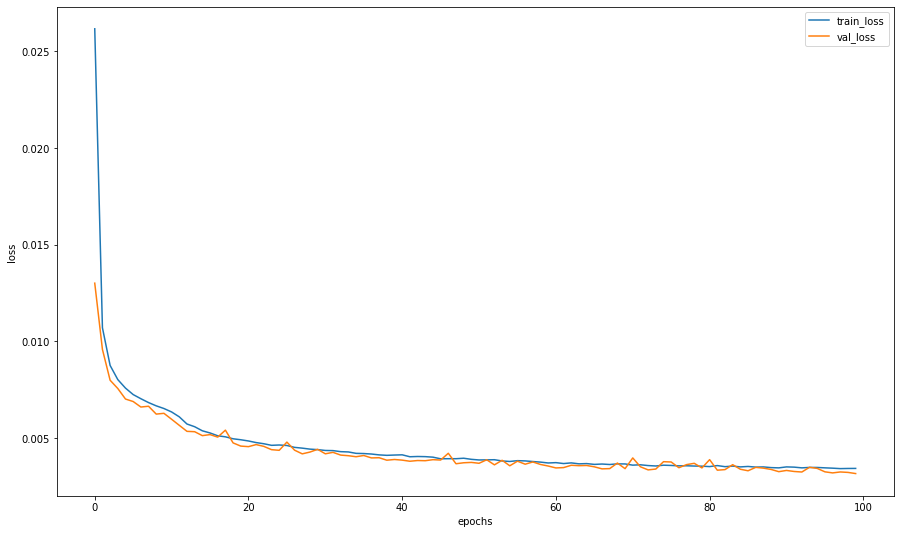

In [160]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

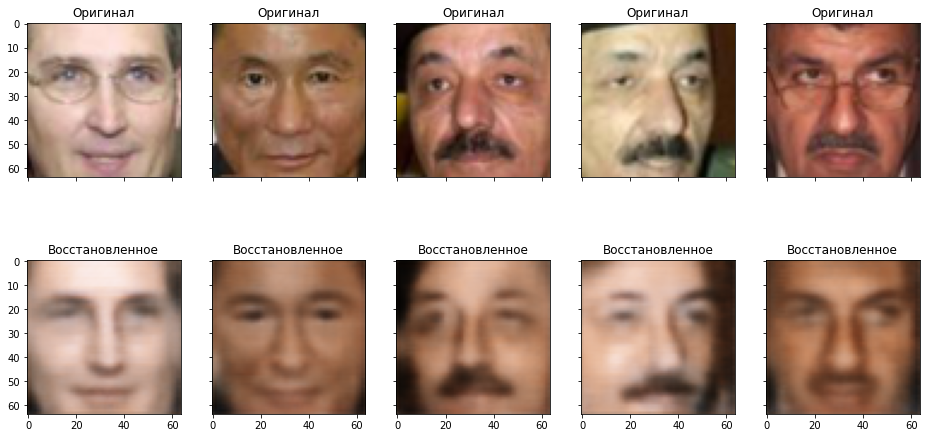

In [169]:
num_images = 5
fig, axes = plt.subplots(nrows=2, ncols=num_images,figsize=(16, 8), sharey=True, sharex=True)

for i in range(num_images):
    id = int(np.random.randint(0,len(val_loader)))
    val_image = val_loader.dataset[id] 
    axes[0, i].imshow(val_image.transpose(1, 2, 0))
    axes[0, i].set_title('Оригинал')

    pred, latent = autoencoder(torch.FloatTensor(val_image.reshape(-1, 3, 64, 64)).to(device))
    axes[1, i].imshow(pred[0].to('cpu').detach().numpy().transpose(1, 2, 0))
    axes[1, i].set_title('Восстановленное')

Not bad, right? Right!

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [170]:
train_latent = []
autoencoder.eval()
with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(device)
        _, latent = autoencoder(batch)
        train_latent.append(latent.to('cpu').detach().numpy().squeeze())
train_latent = np.concatenate(train_latent,0)
train_latent = train_latent.T

In [83]:
mean_std = [[],[]]
for i in range(train_latent.shape[0]):
    mean_std[0].append(np.mean(train_latent[i]))
    mean_std[1].append(np.std(train_latent[i]))

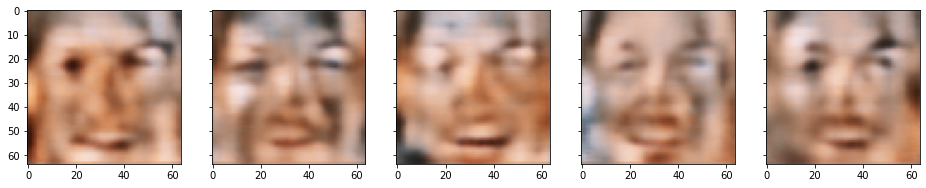

In [181]:
num_images = 5
fig, axes = plt.subplots(nrows=1, ncols=num_images,figsize=(16, 8), sharey=True, sharex=True)

for i in range(num_images):
    z = mean_std[0] + mean_std[1] * np.random.randn(1, 128)
    z = z.reshape(1, 128, 1, 1)
    z = torch.FloatTensor(z)
    z  = z.to(device)
    
    pred = autoencoder(z, True)

    axes[i].imshow(pred[0].to('cpu').detach().numpy().transpose(1, 2, 0))

plt.show()

В простом автоэнкодере большой разбос в значениях признаков латентного вектора и довольно трудно подобрать закономерность. Если сгенирировать нормальный вектор, то на изображении даже не будет подобия лица. Для того, чтобы получить приведенный выше результат пришлось найти среднее значение и стандартное отклоние для всех признаков в латентном векторе для тренировочной выборки. 

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [182]:
#Получаем индексы улыбчивых людей
smiling_id = attrs.sort_values(by='Smiling', axis=0, ascending=False)['Smiling'][:15].index.tolist()
#Получаем индексы грустных людей
sad_id = attrs.sort_values(by='Smiling', axis=0, ascending=True)['Smiling'][:15].index.tolist()

In [183]:
smiling_loader = torch.utils.data.DataLoader(data[smiling_id].transpose(0, 3, 1, 2).astype(np.float32), batch_size=1, shuffle=False)
sad_loader = torch.utils.data.DataLoader(data[sad_id].transpose(0, 3, 1, 2).astype(np.float32), batch_size=1, shuffle=False)

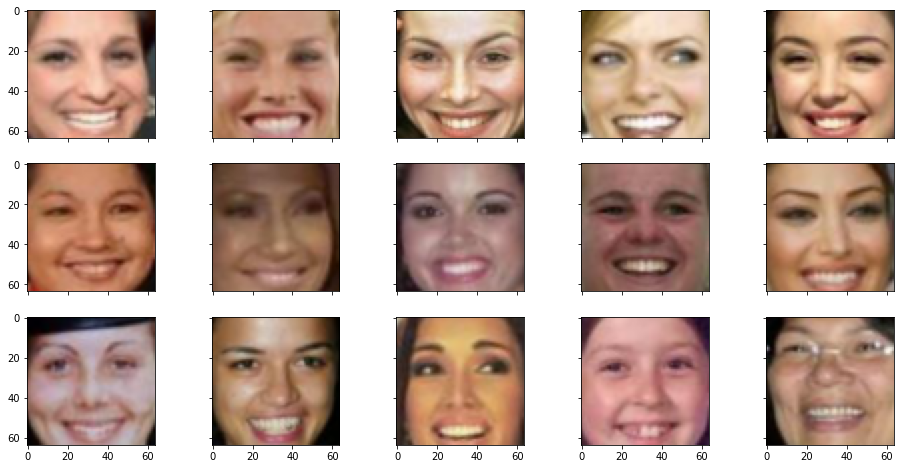

In [184]:
fig, ax = plt.subplots(nrows=3, ncols=5,figsize=(16, 8), \
                        sharey=True, sharex=True)
id = 0
for fig_x in ax.flatten():
    fig_x.imshow(smiling_loader.dataset[id].transpose(1, 2, 0))
    id +=1


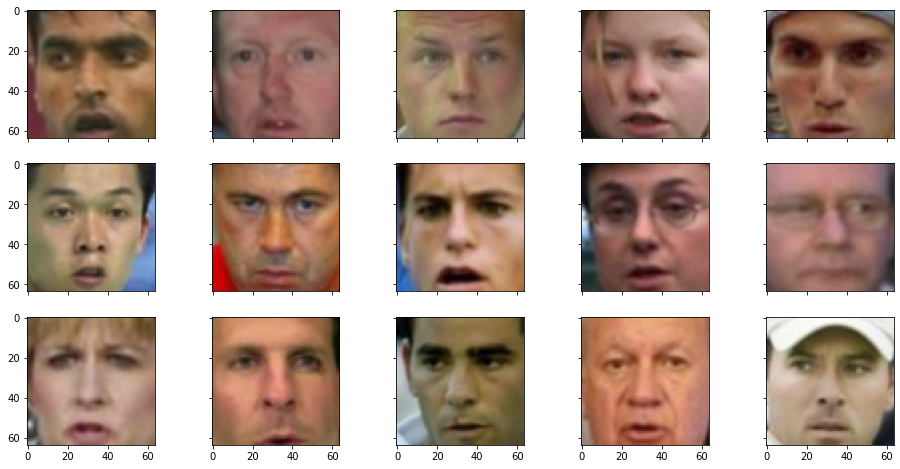

In [185]:
fig, ax = plt.subplots(nrows=3, ncols=5,figsize=(16, 8), \
                        sharey=True, sharex=True)
id = 0
for fig_x in ax.flatten():
    fig_x.imshow(sad_loader.dataset[id].transpose(1, 2, 0))
    id +=1

In [186]:
smiling_latent = []
autoencoder.eval()
with torch.no_grad():
    for batch in smiling_loader:
        batch = batch.to(device)
        _, latent = autoencoder(batch)
        smiling_latent.append(latent.to('cpu').detach().numpy().squeeze())
smiling_latent = np.array(smiling_latent)
smiling_vector = smiling_latent.mean(axis=0)

In [187]:
sad_latent = []
autoencoder.eval()
with torch.no_grad():
    for batch in sad_loader:
        batch = batch.to(device)
        _, latent = autoencoder(batch)
        sad_latent.append(latent.to('cpu').detach().numpy().squeeze())
sad_latent = np.array(sad_latent)
sad_vector = sad_latent.mean(axis=0)

In [188]:
smiling_vector = smiling_vector-sad_vector

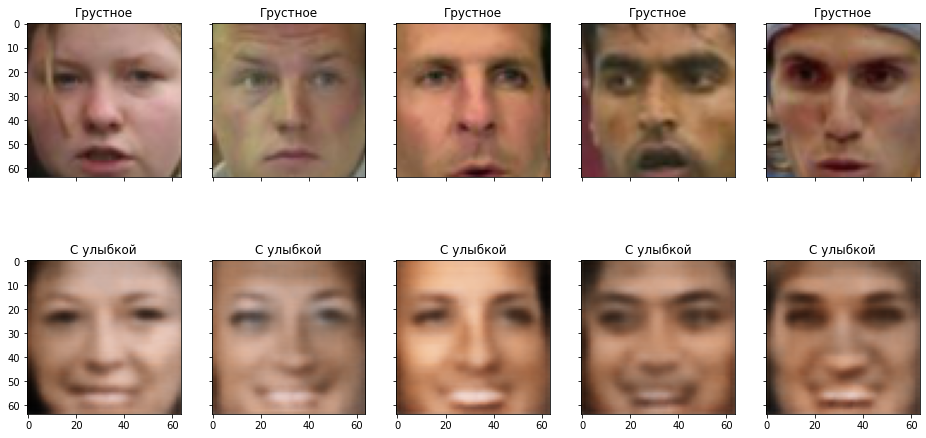

In [190]:
num_images = 5
fig, axes = plt.subplots(nrows=2, ncols=num_images,figsize=(16, 8), sharey=True, sharex=True)

for i in range(num_images):
    id = np.random.randint(0, len(sad_loader))

    axes[0, i].imshow(sad_loader.dataset[id].transpose(1, 2, 0))
    axes[0, i].set_title('Грустное')
    
    pred = autoencoder(torch.FloatTensor((sad_latent[id]+smiling_vector).reshape(1,128,1,1)).to(device), True)

    axes[1, i].imshow(pred[0].to('cpu').detach().numpy().transpose(1, 2, 0))
    axes[1, i].set_title('С улыбкой')

Если посмотреть на выборку улыбающихся людей, то можно заметить, что большинство из их женщины, а среди грустных - большинство мужчин. Вследствие чего, помимо добавления улыбки, изменяется пол на женский.

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [191]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [192]:
features = 32

class VAE(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.features = features
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=32),        
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*4*4, features * 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(features, 32*4*4),
            nn.Unflatten(1, (32, 4, 4)),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=5, stride=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 2, self.features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            return mu + std * torch.randn_like(std)
        else:
            return mu
    
    def decode(self, z):       
        return self.decoder(z)

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [193]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [220]:
criterion = loss_vae

autoencoder = VAE(features)

autoencoder=autoencoder.to(device)

In [221]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

In [196]:
def train_epoch(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = 0.0
    for batch, _ in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        mu, logsigma, reconstruction = model(batch)

        loss = criterion(batch, mu, logsigma, reconstruction)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    return train_loss

In [197]:
def val_epoch(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch, _ in val_loader:
            batch = batch.to(device)
            mu, logsigma, reconstruction = model(batch)

            loss = criterion(batch, mu, logsigma, reconstruction)

            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    return val_loss

In [222]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = []
    model = model.to(device)
    for epoch in tqdm(range(epochs)):
        clear_output(wait=True)

        train_loss = train_epoch(model, criterion, optimizer, train_loader, device)
        val_loss = val_epoch(model, criterion, val_loader, device)
        print('Epoch: %d, train_loss: %f, val_loss: %f' % (epoch, train_loss, val_loss))
        
        history.append((train_loss, val_loss))
        
        id = int(np.random.uniform(0,len(val_loader)))
        val_image = val_loader.dataset[id][0]  
        fig, axes = plt.subplots(1, 2)

        axes[0].imshow(val_image.numpy().transpose(1, 2, 0).squeeze())
        axes[0].set_title('Оригинал')

        mu, logsigma, reconstruction = model(torch.FloatTensor(val_image.reshape(-1, 1, 28, 28)).to(device))

        axes[1].imshow(reconstruction[0].to('cpu').detach().numpy().transpose(1, 2, 0).squeeze())
        axes[1].set_title('Восстановленное')
        
        plt.show()

    return history

Epoch: 99, train_loss: 3163.040746, val_loss: 2842.924727


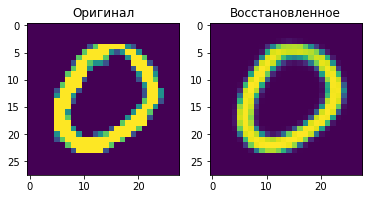












100%|██████████| 100/100 [28:20<00:00, 17.00s/it]


In [223]:
history = train(autoencoder, criterion, optimizer, train_loader, test_loader, 100, device)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [224]:
train_loss, val_loss = zip(*history)

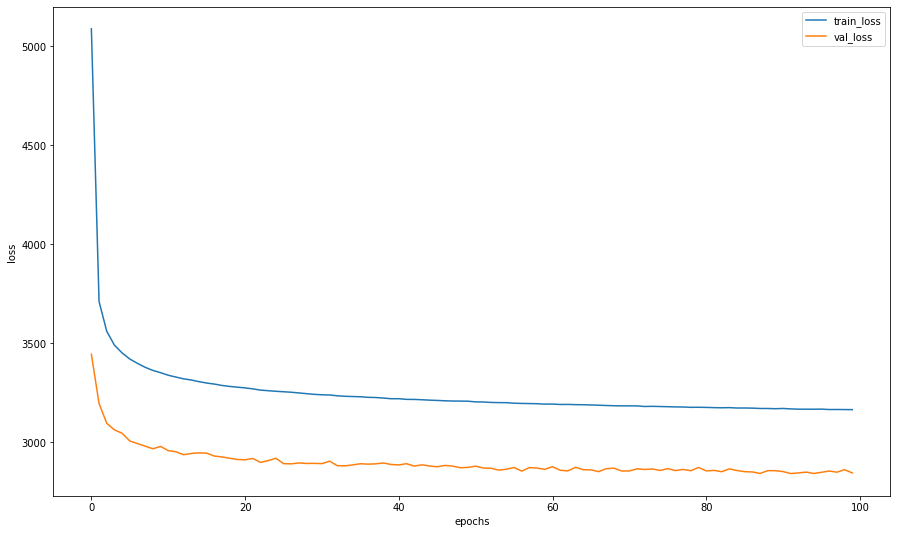

In [225]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

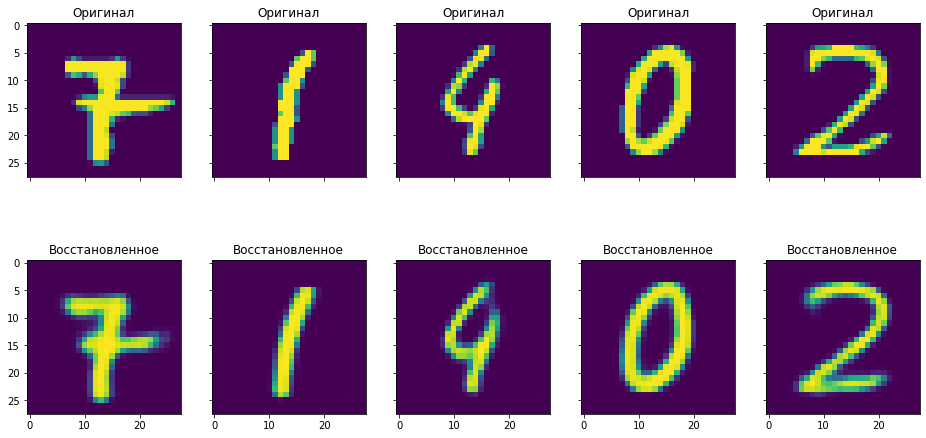

In [226]:
num_images = 5
fig, axes = plt.subplots(nrows=2, ncols=num_images,figsize=(16, 8), sharey=True, sharex=True)

for i in range(num_images):
    id = int(np.random.randint(0,len(test_loader)))
    val_image = test_loader.dataset[id][0] 
    axes[0, i].imshow(val_image.numpy().transpose(1, 2, 0).squeeze())
    axes[0, i].set_title('Оригинал')

    mu, logsigma, reconstruction = autoencoder(torch.FloatTensor(val_image.reshape(-1, 1, 28, 28)).to(device))

    axes[1, i].imshow(reconstruction[0].to('cpu').detach().numpy().transpose(1, 2, 0).squeeze())
    axes[1, i].set_title('Восстановленное')

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

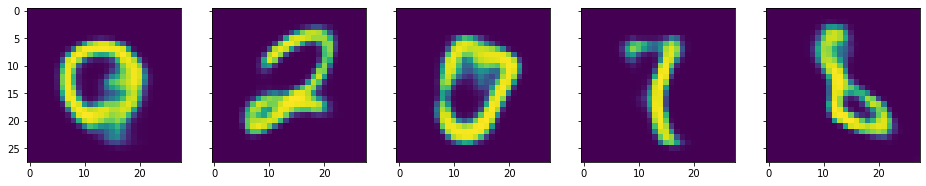

In [232]:
num_images = 5
fig, axes = plt.subplots(nrows=1, ncols=num_images,figsize=(16, 8), sharey=True, sharex=True)

for i in range(num_images):
    z = np.array([np.random.normal(0, 1, 32)])
    z = torch.FloatTensor(z)
    z  = z.to(device)
    
    pred = autoencoder.decode(z)

    axes[i].imshow(pred[0].to('cpu').detach().numpy().transpose(1, 2, 0).squeeze())

plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [237]:
from sklearn.manifold import TSNE

In [239]:
vect = [[] for i in range(10)]
with torch.no_grad():
    for batch, label in test_loader:
        batch = batch.to(device)
        mu, logsigma = autoencoder.encode(batch)
        latent = autoencoder.gaussian_sampler(mu, logsigma).to('cpu').detach().numpy()
        label = label.numpy()
        for num in range(label.shape[0]):
            vect[label[num]].append(latent[num])

In [240]:
x = TSNE(n_components=2).fit_transform(np.concatenate(vect, 0))

In [241]:
counter = 0
for i in range(len(vect)):
    for j in range(len(vect[i])):
        vect[i][j] = x[counter]
        counter += 1

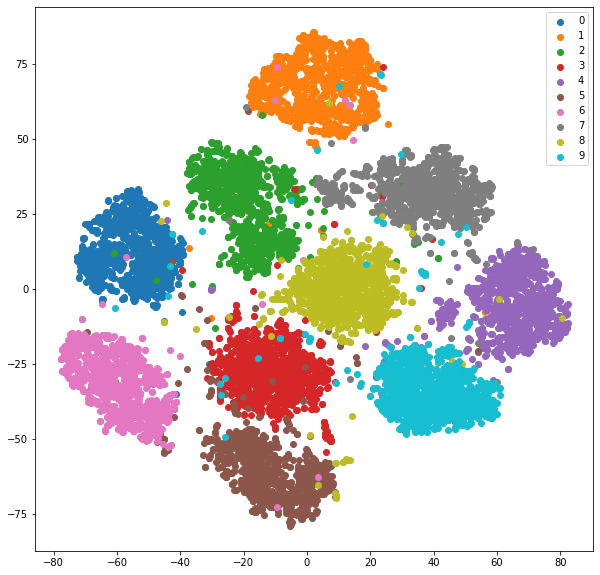

In [242]:
fig, ax = plt.subplots()

for i, a in enumerate(vect):
  a = np.array(a)
  ax.scatter(a[:,0], a[:, 1], label='%d' % (i))
fig.set_figwidth(10)    #  ширина и
fig.set_figheight(10)    #  высота "Figure"
plt.legend()
plt.show()

Что вы думаете о виде латентного представления?

VAE сгруппировал каждый из классов определив для каждого из параметров латентного вектора среднее значение и стандартное отклонение, которые подчиняются нормальному закону. Вследствие чего мы можем более эффективно передвигаться по скрытому пространству и генерировать новые данные.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [261]:
def one_hot(labels, class_size):
    targets = torch.zeros(len(labels), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets

In [262]:
class CVAE(nn.Module):
    def __init__(self, features, num_classes):
        super().__init__()
        self.features = features
        self.num_classes = num_classes
        self.encoder = nn.Sequential(
            nn.Linear(28*28+self.num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, self.features*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.features + self.num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        x = x.view(-1, 28*28)
        x = torch.cat([x, class_num], 1)

        x = self.encoder(x)
        
        x = x.view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            return mu + std * torch.randn_like(std)
        else:
            return mu
    
    def decode(self, z, class_num):
        z = torch.cat([z, class_num], 1)
        reconstruction = self.decoder(z)
        
        return reconstruction.view(-1, 1, 28, 28)

    def forward(self, x, class_num):
        
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)  
        
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [263]:
def train_epoch(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = 0.0
    for batch, labels in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        labels = one_hot(labels, 10).to(device)
        mu, logsigma, reconstruction = model(batch, labels)

        loss = criterion(batch, mu, logsigma, reconstruction)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    return train_loss

In [264]:
def val_epoch(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch, labels in val_loader:
            batch = batch.to(device)
            labels = one_hot(labels, 10).to(device)
            mu, logsigma, reconstruction = model(batch, labels)

            loss = criterion(batch, mu, logsigma, reconstruction)

            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    return val_loss

In [265]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = []
    image, labels = next(iter(val_loader))
    for epoch in tqdm(range(epochs)):
        clear_output(wait=True)
        
        train_loss = train_epoch(model, criterion, optimizer, train_loader, device)
        val_loss = val_epoch(model, criterion, val_loader, device)

        print('Epoch: %d, train_loss: %f, val_loss: %f' % (epoch, train_loss, val_loss))
        
        history.append((train_loss, val_loss))
        
        id = int(np.random.uniform(0,len(val_loader)))
        val_image, labels = val_loader.dataset[id]
        fig, axes = plt.subplots(1, 2)

        axes[0].imshow(val_image.numpy().transpose(1, 2, 0).squeeze())
        axes[0].set_title('Оригинал')

        mu, logsigma, reconstruction = autoencoder(torch.FloatTensor(
            val_image.reshape(-1, 1, 28, 28)).to(device), 
            one_hot(np.array([labels]), 10).to(device))

        axes[1].imshow(reconstruction[0].to('cpu').detach().numpy().transpose(1, 2, 0).squeeze())
        axes[1].set_title('Восстановленное')
        
        plt.show()

    return history

In [266]:
features = 16
num_classes = 10

In [267]:
criterion = loss_vae

autoencoder = CVAE(features, num_classes)

autoencoder= autoencoder.to(device)

In [268]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

Epoch: 99, train_loss: 3110.014298, val_loss: 2900.915503


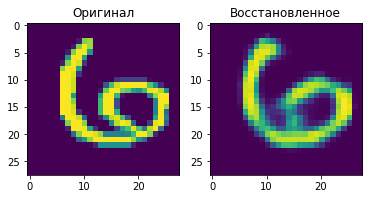
















100%|██████████| 100/100 [15:53<00:00,  9.53s/it]


In [269]:
history = train(autoencoder, criterion, optimizer, train_loader, test_loader, 100, device)

In [308]:
train_loss, val_loss = zip(*history)

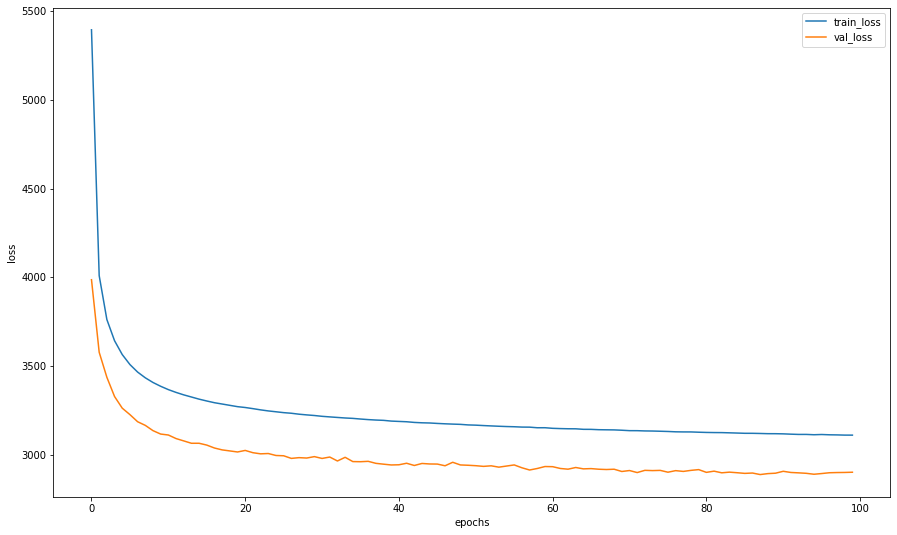

In [309]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

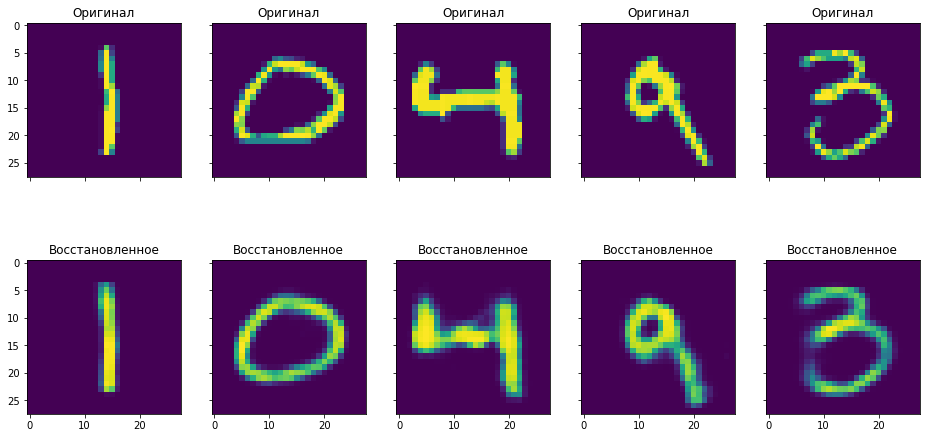

In [302]:
num_images = 5
fig, axes = plt.subplots(nrows=2, ncols=num_images,figsize=(16, 8), sharey=True, sharex=True)

for i in range(num_images):
    id = int(np.random.randint(0,len(test_loader)))
    val_image, labels = test_loader.dataset[id]
    axes[0, i].imshow(val_image.numpy().transpose(1, 2, 0).squeeze())
    axes[0, i].set_title('Оригинал')

    mu, logsigma, reconstruction = autoencoder(
        torch.FloatTensor(val_image.reshape(-1, 1, 28, 28)).to(device),
                          one_hot(np.array([labels]), 10).to(device))

    axes[1, i].imshow(reconstruction[0].to('cpu').detach().numpy().transpose(1, 2, 0).squeeze())
    axes[1, i].set_title('Восстановленное')

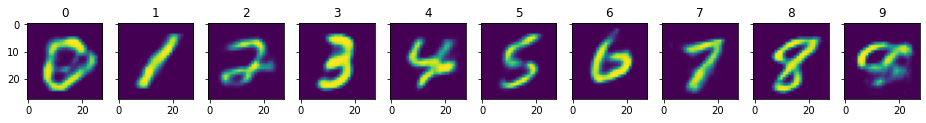

In [295]:
z = np.asarray([np.random.normal(0, 1, 16) for i in range(10)])
labels = torch.tensor([i for i in range(10)])
output = autoencoder.decode(torch.FloatTensor(z).to(device), one_hot(labels, 10).to(device))

num_images = 10
fig, axes = plt.subplots(nrows=1, ncols=num_images,figsize=(16, 8), sharey=True, sharex=True)

for i in range(num_images):

    axes[i].imshow(output[i].to('cpu').detach().numpy().transpose(1, 2, 0).squeeze())
    axes[i].set_title('%d' % labels[i])

plt.show()


Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [303]:
vect = [[] for i in range(10)]
with torch.no_grad():
    for batch, label in test_loader:
        batch = batch.to(device)
        mu, logsigma = autoencoder.encode(batch, one_hot(label, 10).to(device))
        latent = autoencoder.gaussian_sampler(mu, logsigma).to('cpu').detach().numpy()
        label = label.numpy()
        for num in range(label.shape[0]):
            vect[label[num]].append(latent[num])

In [305]:
x = TSNE(n_components=2).fit_transform(np.concatenate(vect,0))

In [306]:
counter = 0
for i in range(len(vect)):
    for j in range(len(vect[i])):
        vect[i][j] = x[counter]
        counter += 1

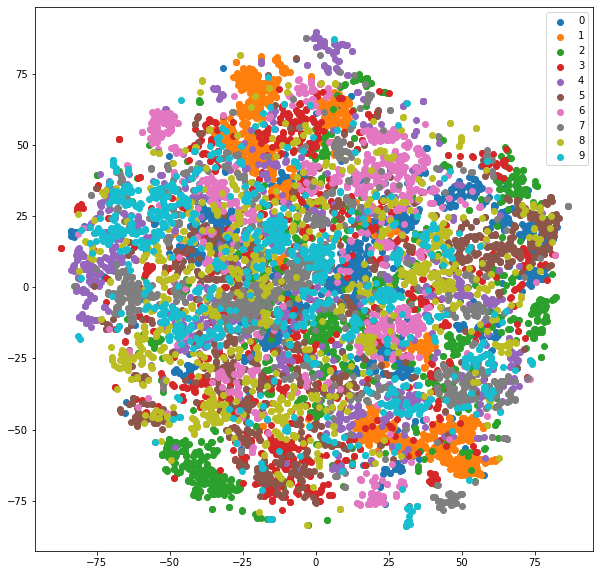

In [307]:
fig, ax = plt.subplots()

for i, a in enumerate(vect):
  a = np.array(a)
  ax.scatter(a[:,0], a[:, 1], label='%d' % (i))
fig.set_figwidth(10)    #  ширина и
fig.set_figheight(10)    #  высота "Figure"
plt.legend()
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

На данной картинке пространство признаков разных классов смешано, и чтобы сгенерировать изображение необходимо указать пространство признаков какого класса нужно использовать. Тем самым cvae может воспроизвести различные классы используя один и тот же латентный вектор. Это упрощает генерацию и делает ее более качественной в отличие от vae.